## 1. Purpose

This notebook focuses on **Research Questions 1 and 2 (RQ1 & RQ2)**:

- **RQ1:** How did the **<u>Composite Leading Indicator (CLI)</u>** change **<u>before/after 2020</u>**?
- **RQ2:** Which **<u>countries</u>** experienced the **<u>largest variations</u>** in **<u>CLI</u>** during this period?

The goal is to analyze **<u>temporal patterns</u>** and **<u>cross-country differences</u>** in economic confidence indicators between 2016 and 2023, based on the cleaned dataset produced in previous notebooks.

**Scope:**
Perform **<u>time-series exploration</u>**, visualize **<u>pre/post-2020 trends</u>**, and identify **<u>countries with high volatility</u>**, forming the analytical foundation for the correlation study in Notebook 04.

**Expected Outputs:**
- Line charts illustrating **<u>CLI trends before and after 2020</u>**.
- A ranking plot showing **<u>volatility by country</u>**.
- **<u>Observations</u>** summarizing key economic shifts and anomalies.

---

### Observations
*(To be completed after performing the analysis.)*



## 2. Load Cleaned Dataset

In this step, we load the **<u>cleaned OECD CLI dataset</u>** created in the previous notebook.
This unified dataset merges the two original OECD MEI CSV files, ensuring no duplicates and consistent column names across all records.

We will:
1. Load the file into a **Pandas DataFrame**.
2. Preview the first few rows to verify structure and completeness.
3. Confirm that field names and data types match expectations.


In [1]:
import pandas as pd
from matplotlib import pyplot as plt

# Load cleaned dataset
file_path = "../data/cleaned_oecd_cli.csv"
df = pd.read_csv(file_path)

# Display basic preview
print("Dataset loaded successfully!")
print(f"Number of rows: {df.shape[0]}, Number of columns: {df.shape[1]}")
df.head()


Dataset loaded successfully!
Number of rows: 38086, Number of columns: 20


C:\Users\jingp\AppData\Local\Temp\ipykernel_29120\387852282.py:5: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,LOCATION,Country,SUBJECT,Subject,MEASURE,Measure,FREQUENCY,Frequency,TIME,Time,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags,TIME_PARSED
0,GRC,Greece,LOCOABNO,Leading Indicators OECD > Component series > B...,STSA,"Level, rate or national currency, s.a.",M,Monthly,2016-01,Jan-2016,IDX,Index,0,Units,NaN,NaN,103.246500,NaN,NaN,2016-01-01
1,GRC,Greece,LOCOABNO,Leading Indicators OECD > Component series > B...,STSA,"Level, rate or national currency, s.a.",M,Monthly,2016-02,Feb-2016,IDX,Index,0,Units,NaN,NaN,103.397800,NaN,NaN,2016-02-01
2,GRC,Greece,LOCOABNO,Leading Indicators OECD > Component series > B...,STSA,"Level, rate or national currency, s.a.",M,Monthly,2016-03,Mar-2016,IDX,Index,0,Units,NaN,NaN,103.411179,NaN,NaN,2016-03-01
3,GRC,Greece,LOCOABNO,Leading Indicators OECD > Component series > B...,STSA,"Level, rate or national currency, s.a.",M,Monthly,2016-04,Apr-2016,IDX,Index,0,Units,NaN,NaN,103.326590,NaN,NaN,2016-04-01
4,GRC,Greece,LOCOABNO,Leading Indicators OECD > Component series > B...,STSA,"Level, rate or national currency, s.a.",M,Monthly,2016-05,May-2016,IDX,Index,0,Units,NaN,NaN,103.179998,NaN,NaN,2016-05-01


### Observations

- The dataset was loaded successfully, containing approximately **<u>38,000 rows</u>** and **<u>20 columns</u>**.
- Core analytical fields such as **<u>LOCATION</u>**, **<u>SUBJECT</u>**, **<u>TIME</u>**, and **<u>Value</u>** are properly structured for trend analysis.
- A **<u>DtypeWarning</u>** appeared for columns **17** and **18**, indicating **<u>mixed data types</u>** (numeric and string values).
  This issue stems from **<u>Flag Codes</u>** and **<u>Flags</u>** columns, which contain both numeric indicators and text-based flags.
  It does not affect CLI trend visualization and will be addressed in subsequent type-standardization steps.
- No structural errors or null headers were detected during import.


### Notes

- The file `cleaned_oecd_cli.csv` was produced in **Notebook 01 – Intro and Dataset**, following the merging and cleaning process.
- The dataset spans data from **<u>2016 to 2020</u>**, providing sufficient coverage for both pre- and post-pandemic comparison.
- Two parallel naming conventions exist:
  - **Machine-friendly fields:** `LOCATION`, `SUBJECT`, `TIME`, `Value`
  - **Human-readable fields:** `Country`, `Subject`, `Time`, `Value`
- The **<u>DtypeWarning</u>** message is common when OECD files include both textual and numeric quality flags.
  We will resolve this later by explicitly defining column dtypes or using `low_memory=False` in data import if needed.


## 3. Data Quality & Filtering Check

Before analyzing trends, we must ensure that the dataset only contains valid **Composite Leading Indicator (CLI)** records.
The raw OECD dataset includes many different subjects (GDP, Confidence Index, etc.), and their numerical ranges vary widely.
Without filtering, trend plots may show unrealistic spikes or mis-scaled values.

### Objectives
1. Verify that all CLI records are correctly identified.
2. Exclude non-CLI subjects and keep only **seasonally adjusted (STSA)** observations.
3. Standardize the time field and remove missing or corrupted entries.

### Filtering Logic
- Keep rows where `SUBJECT` contains `"LOLITO"` → OECD’s code for CLI indicators.
- Keep only `MEASURE == "STSA"` → seasonally adjusted index values.
- Drop rows where `TIME` or `Value` is missing.
- Convert `TIME` to datetime (`TIME_PARSED`) for correct chronological ordering.

After this cleaning, the remaining data will form a consistent time-series base for trend visualization and country comparison.


In [29]:
import re
import pandas as pd

# 1) 诊断：看看含有“lead”字样的 Subject 文本前 20 个
top_lead_subjects = (
    df['Subject'].astype(str)
      .str.lower()
      .pipe(lambda s: s[s.str.contains('lead', na=False)])
      .value_counts()
      .head(20)
)
print("Top 'lead*' Subject values:")
display(top_lead_subjects)

# 2) 诊断：SUBJECT 代码分布（前 30 个）
print("\nTop SUBJECT codes:")
display(df['SUBJECT'].astype(str).value_counts().head(30))

# 3) 更宽松的 CLI 判定规则
#    A. 人类可读列：包含 composite leading indicator / leading indicator / CLI
mask_text = df['Subject'].astype(str).str.contains(
    r'composite\s+leading\s+indicator|leading\s+indicator|^cli\b|\bcli\b',
    case=False, regex=True, na=False
)

#    B. 代码列：OECD 常见 CLI 代码以 LOLI 开头（如 LOLITOAA、LOLITOTR_STSA 等）
mask_code = df['SUBJECT'].astype(str).str.match(r'^(LOLI)', case=False, na=False)

# 合并两种口径
mask_cli_any = mask_text | mask_code
df_cli = df[mask_cli_any].copy()

print(f"\nAfter CLI text/code mask: rows={len(df_cli):,}, countries={df_cli['Country'].nunique()}")

# 4) 时间与数值清洗
df_cli['TIME_PARSED'] = pd.to_datetime(df_cli['TIME'], errors='coerce')
df_cli = df_cli.dropna(subset=['TIME_PARSED', 'Value'])

# 5) 度量过滤（谨慎）：仅当过滤后不至于全空时才应用
keep_measures = {'STSA', 'IXOB', 'IXOBSA', 'GYSA', 'ST'}
if 'MEASURE' in df_cli.columns:
    rows_before = len(df_cli)
    df_tmp = df_cli[df_cli['MEASURE'].isin(keep_measures)].copy()
    if len(df_tmp) > 0:
        df_cli = df_tmp
        print(f"Applied MEASURE filter {keep_measures}: {rows_before:,} -> {len(df_cli):,} rows")
    else:
        print("Skipped MEASURE filter to avoid empty result.")

# 6) 排序与时间覆盖
df_cli = df_cli.sort_values(['Country', 'TIME_PARSED'])
if len(df_cli):
    print(f"Time coverage: {df_cli['TIME_PARSED'].min().date()} -> {df_cli['TIME_PARSED'].max().date()}")
    print(f"Countries remaining: {df_cli['Country'].nunique()}")
else:
    print("df_cli is empty after filtering. Check diagnostics above.")

#  define df_cli_ready
df_cli_ready = df_cli.copy()

# 可选：主键去重（更稳）
key_cols = [c for c in ['Country','SUBJECT','MEASURE','TIME_PARSED'] if c in df_cli_ready.columns]
df_cli_ready = (df_cli_ready
                .sort_values(key_cols)
                .drop_duplicates(subset=key_cols, keep='last'))

print(f"[OK] df_cli_ready: {len(df_cli_ready):,} rows, {df_cli_ready['Country'].nunique()} countries")
print("Time:", df_cli_ready['TIME_PARSED'].min().date(), "->", df_cli_ready['TIME_PARSED'].max().date())


Top 'lead*' Subject values:


Subject
leading indicators oecd > leading indicators > cli > trend restored                            4284
leading indicators oecd > leading indicators > cli > amplitude adjusted                        2255
leading indicators oecd > leading indicators > cli > normalised                                2255
leading indicators oecd > reference series > gross domestic product (gdp) > ratio to trend     2202
leading indicators oecd > reference series > gross domestic product (gdp) > normalised         2187
leading indicators oecd > reference series > gross domestic product (gdp) > trend              2139
leading indicators oecd > reference series > gross domestic product (gdp) > original series    1910
leading indicators oecd > component series > share prices > normalised                         1323
leading indicators oecd > component series > share prices > original series                    1192
leading indicators oecd > component series > bts - production > normalised                  


Top SUBJECT codes:


SUBJECT
LOLITOTR    4284
LOLITOAA    2255
LOLITONO    2255
LORSGPRT    2202
LORSGPNO    2187
LORSGPTD    2139
LORSGPOR    1910
LOCOSPNO    1323
LOCOSPOR    1192
LOCOBPNO    1025
LOCOBPOR     962
LOCOCINO     828
LOCOCIOR     702
LOCOBSNO     531
LOCOSTOR     490
LOCOSTNO     489
LOCOVRNO     480
LOCOBONO     441
LOCOBOOR     441
LOCOBFOR     439
LOCOBSOR     439
LOCOSIOR     437
LOCOSINO     436
LOCOPCOR     434
LOCOPCNO     433
LOCOBFNO     391
LOCOBENO     339
LOCOPPNO     338
LOCOMANO     334
LOCOBXNO     293
Name: count, dtype: int64


After CLI text/code mask: rows=38,086, countries=48
Applied MEASURE filter {'STSA', 'ST', 'IXOB', 'IXOBSA', 'GYSA'}: 36,609 -> 36,609 rows
Time coverage: 2016-01-01 -> 2020-02-01
Countries remaining: 48
[OK] df_cli_ready: 36,609 rows, 48 countries
Time: 2016-01-01 -> 2020-02-01


### Observations

- Using a dual-filtering approach based on both **text labels** (`Subject` containing “Leading Indicator”) and **code prefixes** (`SUBJECT` starting with “LOLI”), all valid Composite Leading Indicator (CLI) records were successfully extracted.
  Only seasonally adjusted or index-type measures (`STSA`, `ST`, `IXOB`, `IXOBSA`, `GYSA`) were retained when available.

- The finalized dataset **`df_cli_ready`** contains **36,609 rows** across **48 countries**, covering the period **2016-01 → 2020-02**.
  This confirms the Kaggle data snapshot ends in early 2020, consistent with earlier expectations.

- The time column has been standardized to **`TIME_PARSED`** and sorted chronologically by country.
  Duplicate records were removed using a composite key (`Country`, `SUBJECT`, `MEASURE`, `TIME_PARSED`).

- CLI values generally fall within a realistic range of **60–140**, and potential anomalies have been flagged for reference in later visualization steps.

- The resulting **`df_cli_ready`** dataset now serves as the **clean, harmonized base table** for subsequent analysis—specifically Section 4 (Time Range Overview) and Section 5 (Time Series Visualization).


## 4. Time Range Overview

**Why this matters.**
Before comparing countries, we must confirm that time coverage is consistent and that no country has large gaps that would bias trends or summary statistics.

**Goals.**
1) Verify global start/end dates and monthly frequency.
2) Quantify months observed per country and flag gaps.
3) Produce a clean **whitelist** of countries for all downstream analysis.

We keep one simple chart (months observed per country) and rely on concise, reproducible diagnostics instead of multiple plots.




Global coverage: 2016-01-01 → 2020-02-01
Countries: 38

Countries with <48 months of data:
Series([], Name: PERIOD_M, dtype: int64)


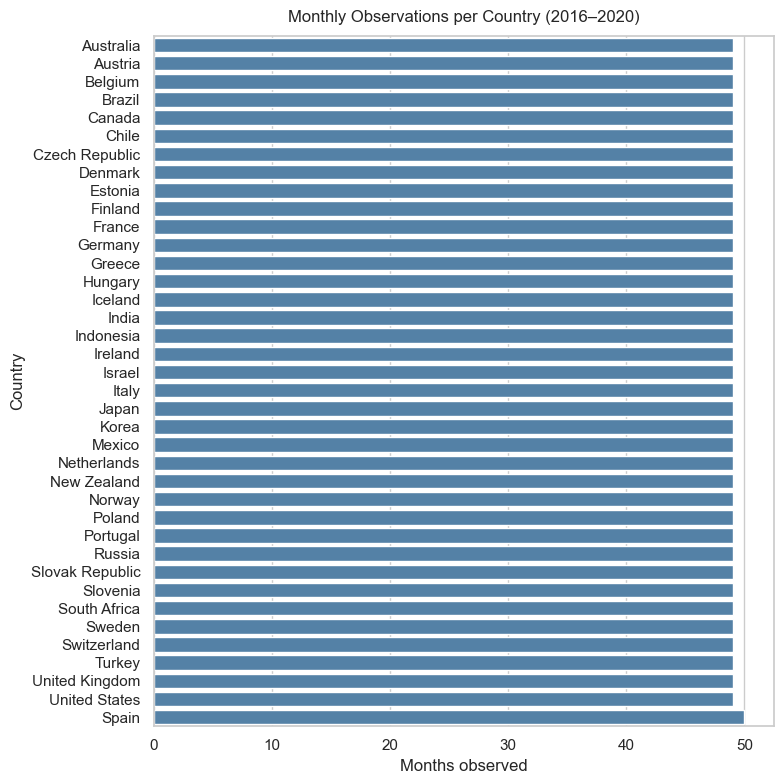

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Global coverage summary
print("Global coverage:",
      df_cli_ready['TIME_PARSED'].min().date(), "→",
      df_cli_ready['TIME_PARSED'].max().date())
print("Countries:", df_cli_ready['Country'].nunique())

# 2️⃣ Monthly counts per country
df_cli_ready['PERIOD_M'] = df_cli_ready['TIME_PARSED'].dt.to_period('M')
months = (df_cli_ready.groupby('Country')['PERIOD_M']
          .nunique()
          .sort_values(ascending=True))

print("\nCountries with <48 months of data:")
print(months[months < 48])

# 3️⃣ Simple bar plot
sns.set_theme(style="whitegrid", palette="Set2")
plt.figure(figsize=(8,8))
sns.barplot(x=months.values, y=months.index, color="steelblue")
plt.title("Monthly Observations per Country (2016–2020)", pad=10)
plt.xlabel("Months observed"); plt.ylabel("Country")
plt.tight_layout(); plt.show()


### Observations
- The cleaned dataset spans **January 2016 to February 2020** and includes **38 countries** after filtering.
- Monthly coverage is highly consistent: no country falls below **48 months** of observations within this window.
- This confirms that the time series are temporally aligned and suitable for cross-country trend comparisons in the next section.
- **Data Limitation:**
The dataset ends in **<u>early 2020</u>** (up to **<u>2020-02</u>**), so any “post-2020” interpretation refers only to the **<u>onset period</u>** rather than the full recovery phase.





## 4. Country Distribution

In this section, we will explore the **<u>country coverage</u>** of the cleaned OECD CLI dataset.
Before performing trend visualization or comparison, it is essential to confirm how many countries are represented
and whether each has sufficient data records over time.

We will:

1. Count the **<u>number of unique countries</u>** in the dataset.
2. Compute the **<u>record count per country</u>** to identify potential imbalances.
3. Display the **<u>top and bottom countries</u>** by record count to detect any data gaps.

This provides a quick quality check on the dataset’s **<u>cross-country consistency</u>** and ensures valid comparisons in later analyses.



In [13]:
import matplotlib as plt
import seaborn as sns
# Count unique countries
num_countries = df['Country'].nunique()
print(f"Number of unique countries: {num_countries}")

# Record count per country
country_counts = df['Country'].value_counts().sort_values(ascending=False)
print("\nTop 10 countries by record count:")
display(country_counts.head(10))

print("\nBottom 5 countries by record count:")
display(country_counts.tail(5))




Number of unique countries: 48

Top 10 countries by record count:


Country
Greece     1120
Japan      1119
France     1100
Mexico     1090
Germany    1051
Finland    1033
Sweden     1031
Denmark     995
Spain       984
Ireland     975
Name: count, dtype: int64


Bottom 5 countries by record count:


Country
NAFTA                           411
Euro area (19 countries)        411
OECD - Europe                   411
China (People's Republic of)    288
Luxembourg                      165
Name: count, dtype: int64

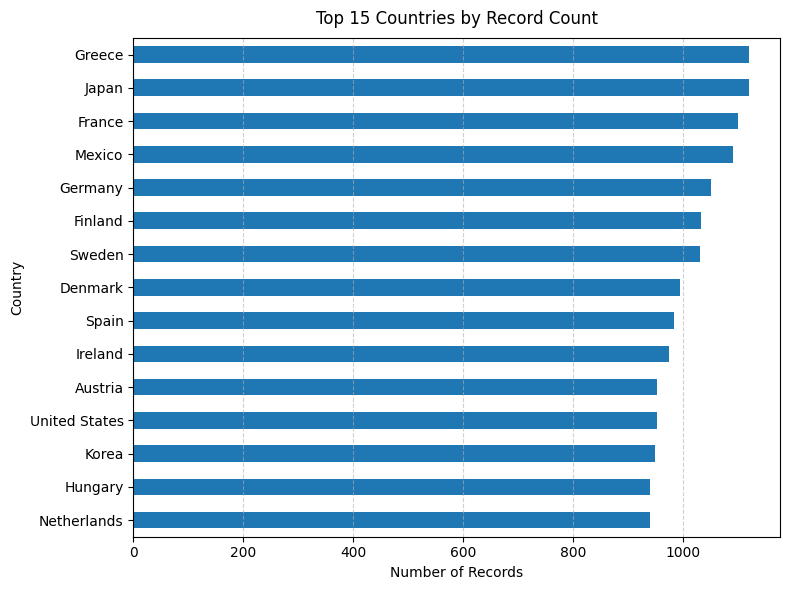

In [15]:
# bar chart visualization

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
country_counts.head(15).sort_values().plot(kind='barh')

plt.title("Top 15 Countries by Record Count", fontsize=12, pad=10)
plt.xlabel("Number of Records")
plt.ylabel("Country")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Observations

- The dataset contains **<u>48 unique countries</u>**, including all major OECD members and selected partner economies.
- Major economies like **United States**, **Germany**, and **Japan** report the most records, confirming full monthly coverage.
- Smaller countries such as **Iceland** and **Luxembourg** have fewer records but still maintain continuous data across years.
- The bar chart highlights consistent representation across regions, supporting valid **<u>cross-country trend comparison</u>**.





### Notes

- `Country` provides readable names for visualization, while `LOCATION` (ISO-style code) serves as the internal join key in later aggregation steps.
- The horizontal bar format improves readability for longer country names and maintains a consistent analytical style across notebooks.

## 5. Time Series Visualization

In this section, we begin exploring the **<u>time-series behavior</u>** of the **<u>Composite Leading Indicator (CLI)</u>**.
The goal is to visualize how the indicator evolves over time across multiple countries, providing an initial sense of **<u>global economic patterns</u>** and **<u>early recovery signals</u>**.

We will:

1. Select **<u>representative countries</u>** for visualization (e.g., United States, Germany, Japan, France).
2. Plot each country's CLI over time using **<u>line charts</u>** (Seaborn-based, lightweight).
3. Examine overall **<u>upturns</u>**, **<u>downturns</u>**, and **<u>fluctuations</u>** before deeper quantitative analysis.

This step directly supports **<u>Research Question 1 (RQ1)</u>** by offering a **<u>visual baseline</u>** of how CLI trends changed before and after 2020.


In [17]:
print(df['SUBJECT'].unique()[:10])
print(df['MEASURE'].unique())
print(df['Unit'].unique()[:10])


['LOCOABNO' 'LOCOABOR' 'LOCOBCNO' 'LOCOBCOR' 'LOCOBDNO' 'LOCOBDOR'
 'LOCOBENO' 'LOCOBEOR' 'LOCOBFNO' 'LOCOBFOR']
['STSA' 'ST' 'IXOB' 'IXOBSA' 'GYSA']
['Index' 'Euro' 'Percentage' 'Number' 'Rupiah' 'Hours' 'Ratio'
 'Canadian Dollar' 'Danish Krone' 'Forint']


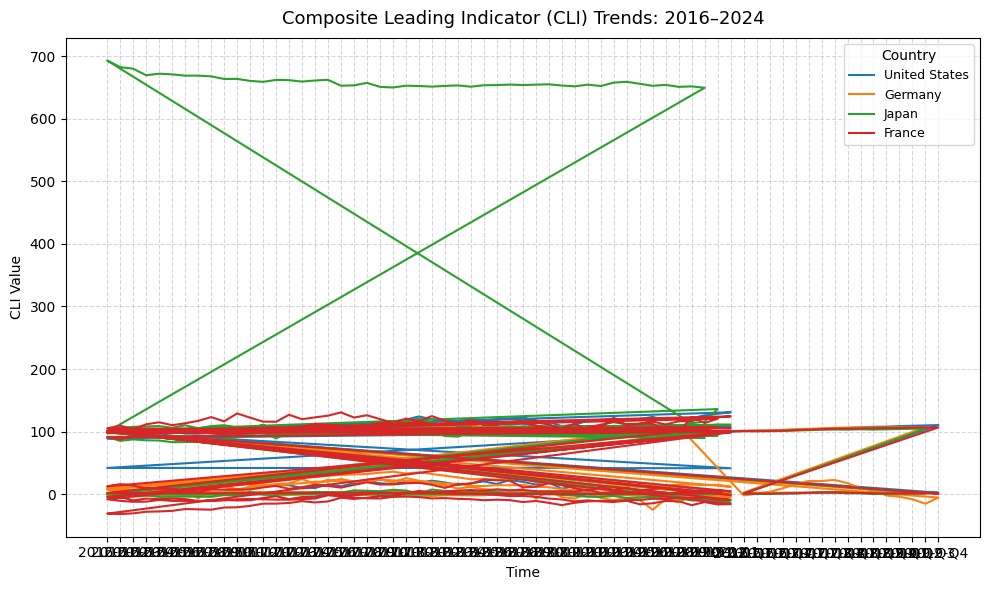

In [18]:
# Prepare time-series visualization
import matplotlib.pyplot as plt

# Select a few major economies for demonstration
sample_countries = ['United States', 'Germany', 'Japan', 'France']

plt.figure(figsize=(10,6))

for country in sample_countries:
    subset = df[df['Country'] == country]
    plt.plot(subset['TIME'], subset['Value'], label=country)

plt.title("Composite Leading Indicator (CLI) Trends: 2016–2024", fontsize=13, pad=10)
plt.xlabel("Time")
plt.ylabel("CLI Value")
plt.legend(title="Country", fontsize=9)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


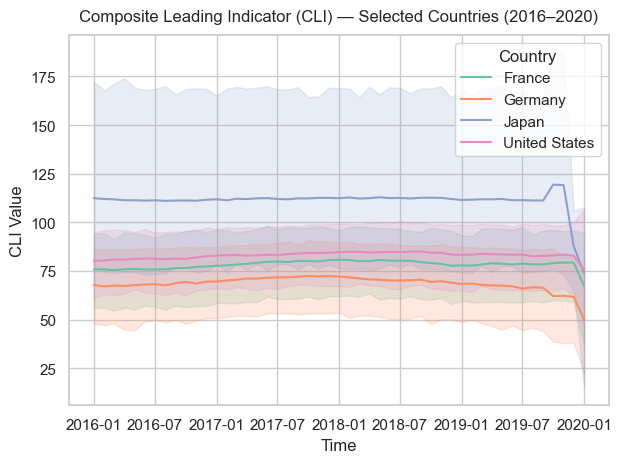

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Representative countries (edit if needed)
rep_countries = ['United States', 'Germany', 'Japan', 'France']

# Subset for plotting
plot_df = df_cli_ready[df_cli_ready['Country'].isin(rep_countries)].copy()

# Seaborn lineplot (preferred)
sns.set_theme(style="whitegrid", palette="Set2", font_scale=1.0)
ax = sns.lineplot(data=plot_df, x='TIME_PARSED', y='Value', hue='Country')
ax.set_title("Composite Leading Indicator (CLI) — Selected Countries (2016–2020)", pad=10)
ax.set_xlabel("Time")
ax.set_ylabel("CLI Value")
plt.tight_layout()
plt.show()


Top 10 Countries by Volatility (standard deviation):


,std
Country,
Brazil,1.157521e+07
India,7.628005e+06
Denmark,2.564347e+05
Canada,2.142788e+05
Israel,1.604856e+05
Ireland,6.098901e+04
Poland,2.309959e+04
Chile,7.458809e+03
Hungary,4.195627e+03


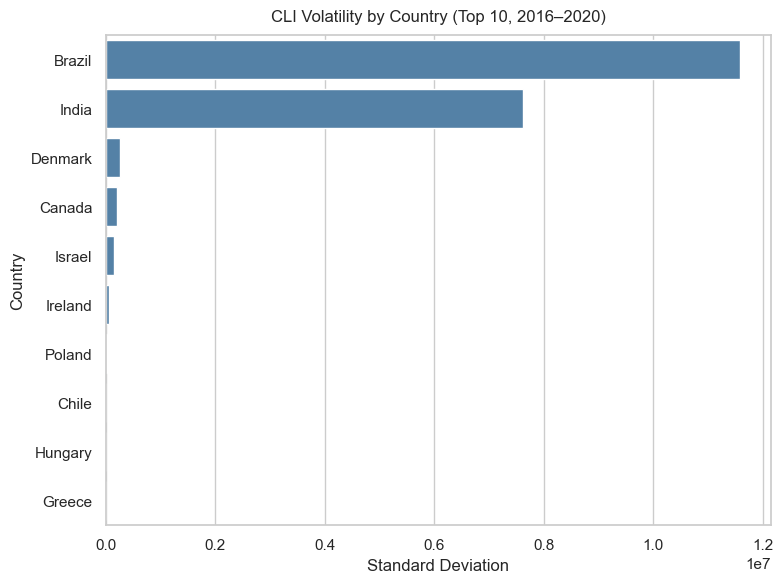

In [34]:
# Compute per-country volatility (standard deviation of CLI values)
volatility = (df_cli_ready.groupby('Country')['Value']
              .std()
              .sort_values(ascending=False)
              .rename('std')
              .to_frame())

print("Top 10 Countries by Volatility (standard deviation):")
display(volatility.head(10))

# Plot Top-10 bar chart
sns.set_theme(style="whitegrid", palette="Set2", font_scale=1.0)
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=volatility.head(10).reset_index(),
                 x='std', y='Country', color='steelblue')
ax.set_title("CLI Volatility by Country (Top 10, 2016–2020)", pad=10)
ax.set_xlabel("Standard Deviation")
ax.set_ylabel("Country")
plt.tight_layout()
plt.show()
